# XGBoost

In [2]:
!pip install xgboost

  Using cached xgboost-2.1.0-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.0-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl (2.1 MB)


## K-Fold Cross-Validationを使用して、モデルの汎化性能を評価

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.05, 'subsample': 0.8}
Best cross-validation MAE: 0.1010
Mean Absolute Error (MAE): 0.1013
Mean Squared Error (MSE): 0.0185
R-squared (R2): 0.8340
Root Mean Squared Error (RMSE): 0.1358
Mean Actual Value: 7.113067736843516
Mean Absolute Percentage Error (MAPE): 1.42%
Mean CV MAE: 0.1218
Mean MAE for different splits: 0.1015
最適なXGBoostモデルが /Users/hayakawakazue/Downloads/second_apt_2024_summer/model/xgboost_0806_2.joblib に保存されました。
     Feature  Importance
0   長期価格トレンド    0.617744
5    面積/築年数比    0.174759
6     建築年スコア    0.058629
8     面積×容積率    0.028574
1  エリア人気度スコア    0.027257
2    市区町村コード    0.024595
3       取引時点    0.021158
7        築年数    0.017442
9   建築年×建ぺい率    0.016332
4    駅距離_面積比    0.013509


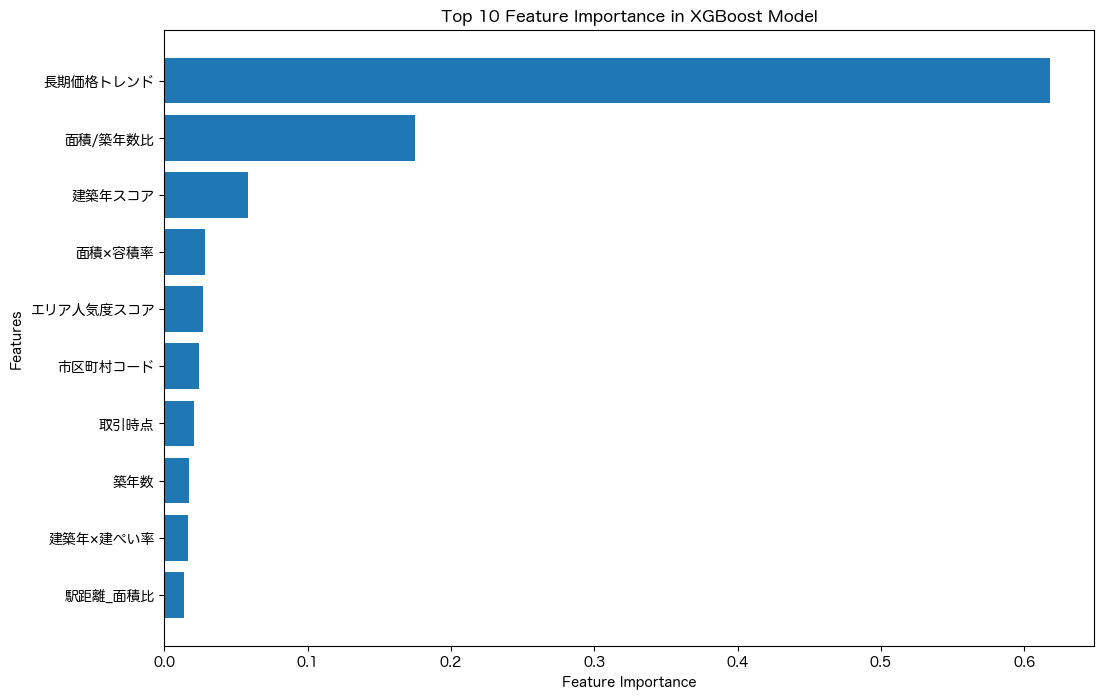

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# 保存されたデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_scaled_features.csv'
data = pd.read_csv(data_path)

# 特徴量の選択
selected_features = [
    '長期価格トレンド', 'エリア人気度スコア', '市区町村コード', 
    '取引時点', '駅距離_面積比', '面積/築年数比', '建築年スコア', 
    '築年数', '面積×容積率', '建築年×建ぺい率'
]

# 特徴量と目的変数を分ける
X = data[selected_features]
y = data['取引価格（総額）_log']

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# XGBoostモデルの定義
xgb_model = xgb.XGBRegressor(random_state=15)

# ハイパーパラメータのグリッド
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01],
    'subsample': [0.2, 0.4, 0.8],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'reg_alpha': [0, 0.01, 0.05],
    'reg_lambda': [0.05, 0.1, 0.5]
}

# グリッドサーチの設定
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)

# グリッドサーチの実行
xgb_grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {xgb_grid_search.best_params_}")
print(f"Best cross-validation MAE: {-xgb_grid_search.best_score_:.4f}")

# 最適なモデルを取得
xgb_best = xgb_grid_search.best_estimator_

# テストデータを使った予測
y_pred = xgb_best.predict(X_test)

# 評価指標の計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# 結果の表示
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 実際の値の平均を計算
mean_actual_value = np.mean(y_test)
print(f"Mean Actual Value: {mean_actual_value}")

# 誤差のパーセンテージを計算
error_percentage = (mae / mean_actual_value) * 100
print(f"Mean Absolute Percentage Error (MAPE): {error_percentage:.2f}%")

# クロスバリデーションの実行
cv_scores = cross_val_score(xgb_best, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = -cv_scores.mean()
print(f"Mean CV MAE: {mean_cv_score:.4f}")

# ランダムステートを変えてのモデル評価（必要に応じてランダムステートのリストを定義）
random_states = [42, 52, 62, 72, 82]
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=state)
    xgb_best.fit(X_train, y_train)
    y_pred = xgb_best.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    scores.append(mae)

mean_mae = np.mean(scores)

print(f"Mean MAE for different splits: {mean_mae:.4f}")

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/second_apt_2024_summer/model', 'xgboost_0806_2.joblib')
joblib.dump(xgb_best, model_path)
print(f"最適なXGBoostモデルが {model_path} に保存されました。")

# 特徴量の重要度を取得
feature_importances = xgb_best.feature_importances_
feature_names = X.columns

# 特徴量の重要度のリストを表示
important_features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
important_features_df = important_features_df.sort_values(by='Importance', ascending=False).head(10)  # 上位10の特徴量のみ表示
print(important_features_df)

# 可視化
plt.figure(figsize=(12, 8))
plt.barh(important_features_df['Feature'], important_features_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()
plt.show()


## 過学習の有無を評価する

Training Mean Absolute Error (MAE): 0.0929
Training Mean Squared Error (MSE): 0.0147
Training R-squared (R2): 0.8679
Training Root Mean Squared Error (RMSE): 0.1213


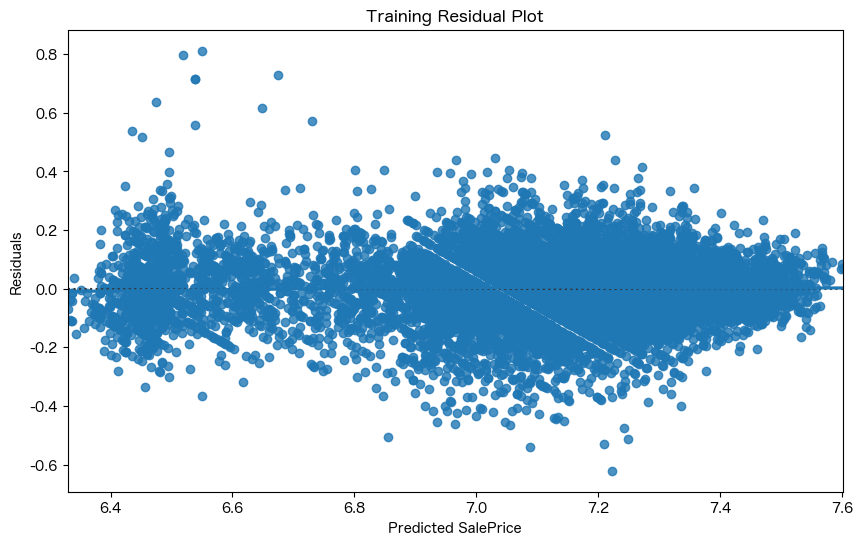

In [2]:
import seaborn as sns

# トレーニングデータを使った予測
y_train_pred = xgb_best.predict(X_train)

# トレーニングデータの評価指標の計算
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# 結果の表示
print(f"Training Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Training R-squared (R2): {train_r2:.4f}")
print(f"Training Root Mean Squared Error (RMSE): {train_rmse:.4f}")

# 残差プロットの作成（トレーニングデータ）
plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_pred, y=(y_train - y_train_pred), lowess=True)
plt.title('Training Residual Plot')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.show()

## クリスバリエーション

In [3]:
from sklearn.model_selection import cross_val_score

# クロスバリデーションの実施
cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# 平均スコアの計算
mean_cv_score = -cv_scores.mean()

print(f"Cross-validation Mean Absolute Error (MAE): {mean_cv_score:.4f}")

Cross-validation Mean Absolute Error (MAE): 0.1010
